In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import os
import numpy as np
import matplotlib.pyplot as plt

root = "/home/jack/ml/imagenet/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/"
root_labels = "/home/jack/ml/imagenet/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/labels.csv"

image_files = []
for item in os.listdir(root):
    image_files.append(item)

image_files.sort()

# Get imagenet labels
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())[1:]

imagenet_labels[517] = "crane_machine"
imagenet_labels[639] = "maillot_but_different"

#image_filename_dataset = tf.data.Dataset.list_files(root + "*", shuffle=False)

all_images = []
for file in image_files:
    all_images.append(os.listdir(root + file))

image_count = []
for i in range(len(all_images)):
    image_count.append(len(all_images[i]))
    
files = []
for i in range(len(image_files)):
    for m in range(len(all_images[i])):
        files.append(root + image_files[i] + "/" + all_images[i][m])

Populating the interactive namespace from numpy and matplotlib


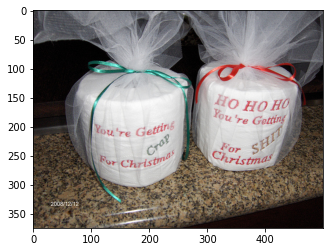

In [6]:
#Load image from file

#%pylab inline
#import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
#img = mpimg.imread(files[len(files) - 1300])
#imgplot = plt.imshow(img)
#plt.show()

In [23]:
#Save labels
#Save as multiple files under same object?

#image_encoding = []
#with open(root_labels,"w") as file:
#    for i in range(len(image_count)):
#        shape = (image_count[i], 1000)
#        one_hot = np.zeros(shape)
#        one_hot[:,i] = 1
#        #for m in range(len(one_hot)):
#        #    numpy.savetxt(file, one_hot[m], delimiter=",")
#        for m in range(len(one_hot)):
#            image_encoding.append(one_hot[m])

In [8]:
#CIFAR dataset

batch_size = 128
(x_train, Y_train), (x_test, Y_test) = tf.keras.datasets.cifar10.load_data()

import numpy as np
all_digits = np.concatenate([x_train, x_test])
all_output = np.concatenate([Y_train, Y_test])
all_output_one_hot = tf.one_hot(np.squeeze(all_output), 10)
all_digits = all_digits.astype("float32") / 255.0

all_digits = np.reshape(all_digits, (-1, 32, 32, 3))
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_output_one_hot))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.batch(batch_size).prefetch(1)

DATASET_SIZE=60000
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

full_dataset = dataset
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

In [26]:
import csv

with open(root_labels, 'w') as file:
    csvwriter = csv.writer(file)
    csvwriter.writerows(image_encoding)

In [2]:
image_filename_dataset = tf.data.Dataset.list_files(files, shuffle=False)
image_data = image_filename_dataset.map(lambda x: tf.io.decode_jpeg(tf.io.read_file(x), channels=3))

2021-12-27 18:06:02.031758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-27 18:06:02.107417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-27 18:06:02.107543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-27 18:06:02.123395: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
labels = tf.data.TextLineDataset(root_labels)

In [4]:
def label_preprocess(line):
    return tf.convert_to_tensor(tf.io.decode_csv(line, record_defaults=[float()] * 1000))

csv_dataset = labels.map(label_preprocess)

def image_preprocess(image):
    image = tf.image.resize(image, (224, 224))
    return image


image_dataset = image_data.map(image_preprocess)

In [5]:
ds = tf.data.Dataset.zip((image_dataset, csv_dataset))
ds = ds.batch(32).prefetch(1)

ds = ds.shuffle(100, reshuffle_each_iteration=True)

In [6]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

iterator = 0

for line in ds.take(20000):
    if iterator > 10000:
        plt.imshow(line[0].numpy().astype(int))
        plt.show()
        print(argmax(line[1]))
    iterator +=1

Populating the interactive namespace from numpy and matplotlib


KeyboardInterrupt: 

In [8]:
DATASET_SIZE=1281167
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

full_dataset = ds
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

In [12]:
input_block = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(224,224,3)),
        tf.keras.layers.Conv2D(64, 7, padding="same", strides=(2,2), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding="same"),
        tf.keras.layers.Conv2D(64, 1, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(64, 3, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(256, 1, padding="same", activation='relu'),
        
        tf.keras.layers.Conv2D(64, 1, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(64, 3, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(256, 1, padding="same", activation='relu'),
        
        tf.keras.layers.Conv2D(64, 1, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(64, 3, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(256, 1, padding="same", activation='relu')
    ], name = "input_block"
)

block_1 = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(56,56,256)),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding="same"),
        tf.keras.layers.Conv2D(128, 1, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(128, 3, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(512, 1, padding="same", activation='relu'),
        
        tf.keras.layers.Conv2D(128, 1, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(128, 3, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(512, 1, padding="same", activation='relu'),
        
        tf.keras.layers.Conv2D(128, 1, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(128, 3, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(512, 1, padding="same", activation='relu'),
        
        tf.keras.layers.Conv2D(128, 1, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(128, 3, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(512, 1, padding="same", activation='relu'),
    ], name = "block_1"
)


block_2 = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(28,28,512)),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding="same"),
        tf.keras.layers.Conv2D(256, 1, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(256, 3, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(1024, 1, padding="same", activation='relu'),
        
        tf.keras.layers.Conv2D(256, 1, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(256, 3, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(1024, 1, padding="same", activation='relu'),
        
        tf.keras.layers.Conv2D(256, 1, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(256, 3, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(1024, 1, padding="same", activation='relu'),
        
        tf.keras.layers.Conv2D(256, 1, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(256, 3, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(1024, 1, padding="same", activation='relu'),
        
        tf.keras.layers.Conv2D(256, 1, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(256, 3, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(1024, 1, padding="same", activation='relu'),
        
        tf.keras.layers.Conv2D(256, 1, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(256, 3, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(1024, 1, padding="same", activation='relu'),
    ], name = "block_2"
)

block_3 = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(14,14,1024)),
        tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding="same"),
        tf.keras.layers.Conv2D(512, 1, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(2048, 1, padding="same", activation='relu'),
        
        tf.keras.layers.Conv2D(512, 1, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(2048, 1, padding="same", activation='relu'),
        
        tf.keras.layers.Conv2D(512, 1, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
        tf.keras.layers.Conv2D(2048, 1, padding="same", activation='relu'),
        tf.keras.layers.AveragePooling2D(pool_size=(7,7), strides=(1, 1), padding='valid'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1000, activation="softmax")
    ], name = "block_3"
)

input_block.summary()
block_1.summary()
block_2.summary()
block_3.summary()

Model: "input_block"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 16, 16, 64)        9472      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_50 (Conv2D)          (None, 8, 8, 64)          4160      
                                                                 
 conv2d_51 (Conv2D)          (None, 8, 8, 64)          36928     
                                                                 
 conv2d_52 (Conv2D)          (None, 8, 8, 256)         16640     
                                                                 
 conv2d_53 (Conv2D)          (None, 8, 8, 64)          16448     
                                                       

In [10]:
class ForcedNet50(tf.keras.Model):
    def __init__(self, input_block, block_1, block_2, block_3):
        super(ForcedNet50, self).__init__()
        
        self.input_block = input_block
        self.output_input = tf.keras.Sequential(
            [
                tf.keras.layers.AveragePooling2D(pool_size=(56,56), strides=(1, 1), padding='valid'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(1000, activation="softmax")
            ]
        )
        
        self.block_1 = block_1
        self.output_1 = tf.keras.Sequential(
            [
                tf.keras.layers.AveragePooling2D(pool_size=(28,28), strides=(1, 1), padding='valid'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(1000, activation="softmax")
            ]
        )
        
        self.block_2 = block_2
        self.output_2 = tf.keras.Sequential(
            [
                tf.keras.layers.AveragePooling2D(pool_size=(14,14), strides=(1, 1), padding='valid'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(1000, activation="softmax")
            ]
        )
        
        self.block_3 = block_3
        #Total Params = 24549736
    def compile(self, optimizer, loss_fn):
        super(ForcedNet50, self).compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
    
    def train_step(self, data):
        images = data[0]
        labels = data[1]
        
        with tf.GradientTape(persistent=True) as tape:
            x = self.input_block(images)
            predictions_input = self.output_input(x)
            
            x = self.block_1(x)
            predictions_1 = self.output_1(x)
            
            x = self.block_2(x)
            predictions_2 = self.output_2(x)

            predictions_3 = self.block_3(x)
            
            loss_input = self.loss_fn(labels, predictions_input)
            loss_1 = self.loss_fn(labels, predictions_1)
            loss_2 = self.loss_fn(labels, predictions_2)
            loss_3 = self.loss_fn(labels, predictions_3)
        
        grads_input = tape.gradient(loss_input, self.input_block.trainable_weights)
        grads_1 = tape.gradient(loss_1, self.block_1.trainable_weights)
        grads_2 = tape.gradient(loss_2, self.block_2.trainable_weights)
        grads_3 = tape.gradient(loss_3, self.block_3.trainable_weights)
        
        grads_input_output = tape.gradient(loss_input, self.output_input.trainable_weights)
        grads_1_output = tape.gradient(loss_1, self.output_1.trainable_weights)
        grads_2_output = tape.gradient(loss_2, self.output_2.trainable_weights)
        
        self.optimizer.apply_gradients(
            zip(grads_input, self.input_block.trainable_weights,)
        )
        self.optimizer.apply_gradients(
            zip(grads_input_output, self.output_input.trainable_weights)
        )
                                
        self.optimizer.apply_gradients(
            zip(grads_1, self.block_1.trainable_weights,)
        )
        self.optimizer.apply_gradients(
            zip(grads_1_output, self.output_1.trainable_weights)
        )
        
        self.optimizer.apply_gradients(
            zip(grads_2, self.block_2.trainable_weights)
        )
        
        self.optimizer.apply_gradients(
            zip(grads_2_output, self.output_2.trainable_weights)
        )
        
        self.optimizer.apply_gradients(
            zip(grads_3, self.block_3.trainable_weights)
        )
        
        return {"Input_Block_Loss": loss_input, "Block_1_Loss": loss_1,
                "Block_2_Loss": loss_2, "Block_3_Loss": loss_3}

In [11]:
ForcedLearner = ForcedNet50(input_block, block_1, block_2, block_3)
ForcedLearner.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=tf.keras.losses.CategoricalCrossentropy(),
)

history = ForcedLearner.fit(train_dataset, batch_size=32, epochs=100)

Epoch 1/100


ValueError: in user code:

    File "/home/jack/ml/my_env/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/home/jack/ml/my_env/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jack/ml/my_env/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/tmp/ipykernel_57149/2801484835.py", line 44, in train_step
        x = self.input_block(images)
    File "/home/jack/ml/my_env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jack/ml/my_env/lib/python3.8/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "input_block" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 32, 32, 3)


In [227]:
model_resnet = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224,224,3), classes=1000)
model_resnet.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003))
model_resnet.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_12[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [214]:
import os

model_temp = tf.keras.applications.MobileNetV2(input_shape=(224,224,3), classes=1000)

opt = tf.keras.optimizers.Nadam(learning_rate=3e-4)

root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir(model_name):
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S") + " " + model_name
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir("MobileNetV2")
callback = [tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=7), tf.keras.callbacks.TensorBoard(run_logdir)]
model_temp.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [174]:
model_temp.compile(loss="Huber", optimizer=opt, metrics=['mse', 'mae','accuracy'])
history = model_temp.fit(train_dataset, batch_size=16, epochs=100, callbacks=[callback],
                    validation_data=(val_dataset))

In [175]:
model_temp.predict(train_dataset.take(1))

array([[5.01614486e-05, 1.19374716e-04, 1.49549696e-05, ...,
        1.48202053e-05, 8.97340578e-06, 2.08578445e-03],
       [4.38345705e-05, 2.87967065e-04, 1.74917968e-05, ...,
        3.17601807e-05, 1.34243062e-04, 2.10764315e-02],
       [6.52964081e-05, 6.18544800e-05, 6.23283777e-05, ...,
        1.89061011e-05, 5.41866211e-06, 5.08765399e-04],
       ...,
       [1.13723336e-05, 6.48208661e-05, 3.53405376e-05, ...,
        4.12471718e-06, 6.82317523e-06, 1.29567704e-03],
       [3.46696470e-05, 6.08464907e-05, 3.51592530e-06, ...,
        9.51840320e-07, 4.30827004e-06, 6.49345820e-05],
       [3.17698752e-04, 5.76441584e-04, 1.39380732e-04, ...,
        8.49801436e-05, 2.69744705e-05, 5.29196206e-03]], dtype=float32)

In [219]:
for line in train_dataset.take(1):
    print(line[1])
    print(argmax(model_temp.predict(train_dataset.take(1))[0]))

tf.Tensor(
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]], shape=(32, 1000), dtype=float32)
794


In [223]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

iterator = 0

for line in ds.take(20000):
    if iterator > 10000:
        plt.imshow(line[0].numpy().astype(int))
        plt.show()
        print(argmax(line[1]))

'shower cap'

In [222]:
imagenet_labels[2]

'great white shark'